In [3]:
import os
import sys
from pathlib import Path
from torch.nn import DataParallel
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from scipy import ndimage
import skimage

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
import cv2

# pv_vision_dir = os.path.join(Path.home(), 'pv-vision')
pv_vision_dir = os.path.join('/home/eccoope', 'pv-vision')
# functions_dir = os.path.join(Path.home(), 'el_img_cracks_ec', 'scripts')
functions_dir = os.path.join('/home/eccoope', 'el_img_cracks_ec', 'scripts')

sys.path.append(pv_vision_dir)
sys.path.append(functions_dir)

import re
import functions
from tutorials.unet_model import construct_unet

import torchvision.transforms.functional as F
from torchvision import transforms

In [2]:
# https://stackoverflow.com/questions/61909973/pytorch-load-incompatiblekeys

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
unet = construct_unet(5)
unet = DataParallel(unet)

weight_path = '/projects/wg-psel-ml/EL_images/osanghi/CornersIHDEANE/checkpoints/retrain_corners_checkpoint3/epoch_30/model.pt'

checkpoint = torch.load(weight_path, map_location=torch.device('cpu'))
from collections import OrderedDict

new_state_dict = OrderedDict()
for k, v in checkpoint.items():
    name = "module." + k
    new_state_dict[name] = v

unet.load_state_dict(new_state_dict)
model = unet.module.to(device)

In [ ]:
# root = Path('/home/eccoope/el_img_cracks_ec/asu3_cropped_rotated')
# root = Path('/projects/wg-psel-ml/EL_images/eccoope/ann_npy_split_cracks/mirrored_xy')
# root = Path('/projects/wg-psel-ml/EL_images/eccoope/img_cropped/mirrored_xy')
# TODO: TEST THIS PATH
root = Path('/projects/wg-psel-ml/EL_images/osanghi/CornersIHDEANE/mirrored_xy') 


transformers = functions.Compose([functions.FixResize(256), functions.ToTensor(), functions.Normalize()])
# files = os.listdir(root)
files = [f for f in os.listdir(root) if f.endswith('.jpg')]
images = [cv2.imread(os.path.join(root, file)) for file in os.listdir(root) if file.endswith('.jpg')]

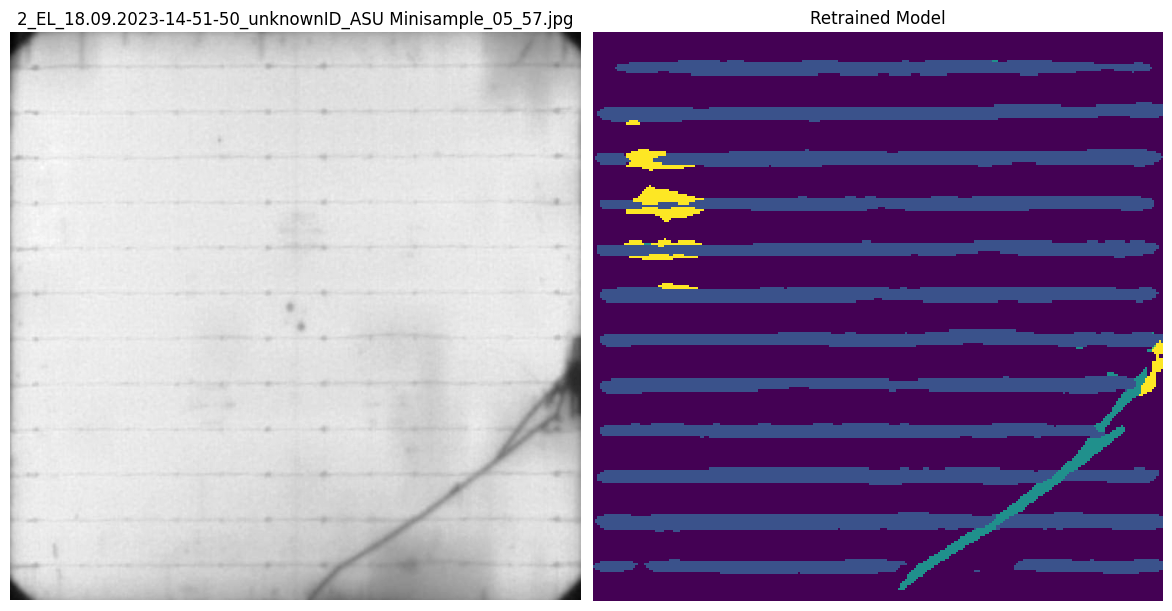

In [ ]:
i = 1

f = files[i]
image = Image.open(os.path.join(root, f))
image = F.resize(image, (256, 256), interpolation=transforms.InterpolationMode.BILINEAR)
image = transforms.ToTensor()(image)
mean=(0.485, 0.456, 0.406)
std=(0.229, 0.224, 0.225)
image = F.normalize(image, mean=mean, std=std)
# image = image.convert( 'L')

image = image.to(device)
test_res = model(image.unsqueeze(0)).detach().cpu().numpy().squeeze()#.argmax(axis = 0)
test_res = np.argmax(test_res, axis = 0)

fig, ax = plt.subplots(ncols=2, figsize=(12,6), layout='compressed')
clim = (0, 4)
im = ax[0].imshow(skimage.color.rgb2gray(images[i]), cmap='gray')
ax[0].axis('off')
ax[0].set_title(f)

ax[1].imshow(test_res, cmap = 'viridis', clim = clim, interpolation='None')
ax[1].set_title("Retrained Model")
ax[1].axis('off')

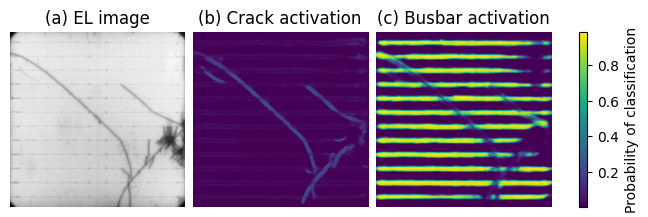

In [127]:
sigmoid = lambda x: 1 /(1 + np.exp(-x))
test_res_chan = model(image.unsqueeze(0)).detach().cpu().numpy().squeeze()
test_res_act = sigmoid(test_res_chan)

cr_layer = test_res_act[2]
bu_layer = test_res_act[1]


fig, ax = plt.subplots(ncols=3, layout='compressed')
ax[0].imshow(skimage.color.rgb2gray(images[i]), cmap='gray')
ax[0].axis('off')
ax[0].set_title('(a) EL image')


ax[1].imshow(cr_layer, cmap='viridis', clim=clim, interpolation='None')
ax[1].axis('off')
ax[1].set_title('(b) Crack activation')
im = ax[2].imshow(bu_layer, cmap='viridis')
ax[2].axis('off')
ax[2].set_title('(c) Busbar activation')
fig.colorbar(im, ax=ax, label='Probability of classification');

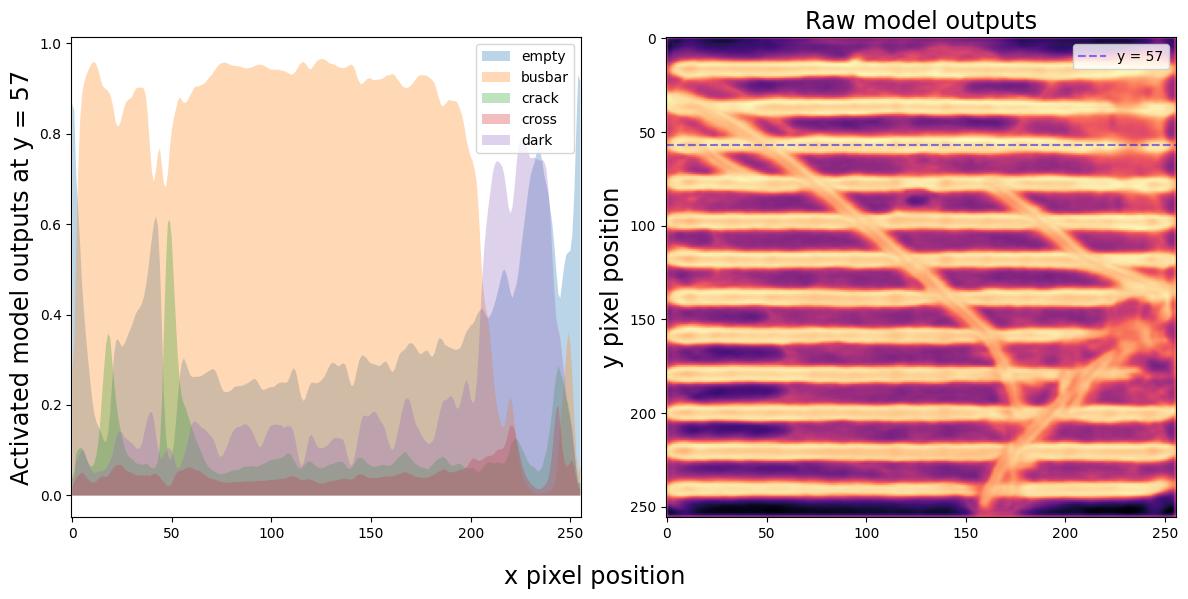

In [ ]:
category_mapping = {0: "empty", 1: "dark", 2: "busbar", 3: "crack", 4: "corner"}

# idx = train_idx[0]

yslice= 57
xmax = 60
ymax = 256

sliced = test_res_act[:, yslice, :]
fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharex=True)

for i in range(sliced.shape[0]):
    ax[0].fill_between(np.arange(0, 256, 1), sliced[i], alpha=0.3, label=category_mapping[i])
ax[0].legend()
ax[0].set_ylabel(f'Activated model outputs at y = {yslice}', fontsize='xx-large')

ax[1].imshow(test_res_chan.sum(axis = 0), cmap  = "magma")
ax[1].set_aspect('auto')
ax[1].axhline(yslice, ls='--', c='b', alpha=0.5, label=f'y = {yslice}')
ax[1].legend()
ax[1].set_title('Raw model outputs', fontsize='xx-large')
ax[1].set_ylabel('y pixel position', fontsize='xx-large')
fig.supxlabel('x pixel position', fontsize='xx-large')
# fig.suptitle(val_loader.dataset. __getname__(cr_idx))
fig.tight_layout()